# Auto Encoders

In [1]:
device = "mps"

In [2]:
from ml_zoo import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm as tqdm
from sklearn.decomposition import PCA
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
dm = MNISTDataModule(
    MNISTDataModuleConfig(
        "data",
        batch_size=128,
        num_workers=4,
        persistent_workers=True,
        pin_memory=True,
        transforms=[torchvision.transforms.ToTensor(), torchvision.transforms.Resize((32, 32))]
    )
)
dm.prepare_data()
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [4]:
def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for x, _ in val_loader:
            x = x.to(device)
            _, loss = model(x, calc_loss=True)
            total_loss += loss.item()

    return total_loss / len(loader)

## Regular Auto Encoder

In [5]:
class Model(nn.Module):
    def __init__(self, latent_dim=4):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),
            
        )

    def forward(self, x, calc_loss) -> tuple[torch.Tensor, torch.Tensor | None]:
        if not calc_loss:
            z = self.encoder(x)
            x_hat = self.decoder(z)
            return x_hat, None

        else:
            z = self.encoder(x)
            x_hat = self.decoder(z)

            loss = F.mse_loss(x_hat, x)
            return x_hat, loss


model = Model().to(device)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
for epoch in range(10):
    model.train()
    val_loss = evaluate(model, val_loader)
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch}")
    for x, _ in pbar:
        x = x.to(device)
        x_hat, loss = model(x, calc_loss=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix_str(
            f"Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Overfit: {loss.item() / val_loss:.4f}"
        )

Epoch 9: 100%|██████████| 469/469 [00:07<00:00, 65.14it/s, Loss: 0.0203, Val Loss: 0.0226, Overfit: 0.9003]


In [8]:
model.eval()
with torch.no_grad():
    values = []
    classes = []
    for x, y in val_loader:
        x = x.to(device)
        z = model.encoder(x)

        values.append(z.cpu().numpy())
        classes.append(y.cpu().numpy().flatten())

    values = np.concatenate(values, axis=0)
    classes = np.concatenate(classes, axis=0)

    # Perform PCA for 3 highest components
    pca = PCA(n_components=2)
    values = pca.fit_transform(values)

    fig = px.scatter(
        x=values[:, 0],
        y=values[:, 1],
        color=classes,
        labels={"values": values},
        title="Latent Space",
        category_orders={"color": np.unique(classes)},
        height=800,
        
    )
    fig.show()

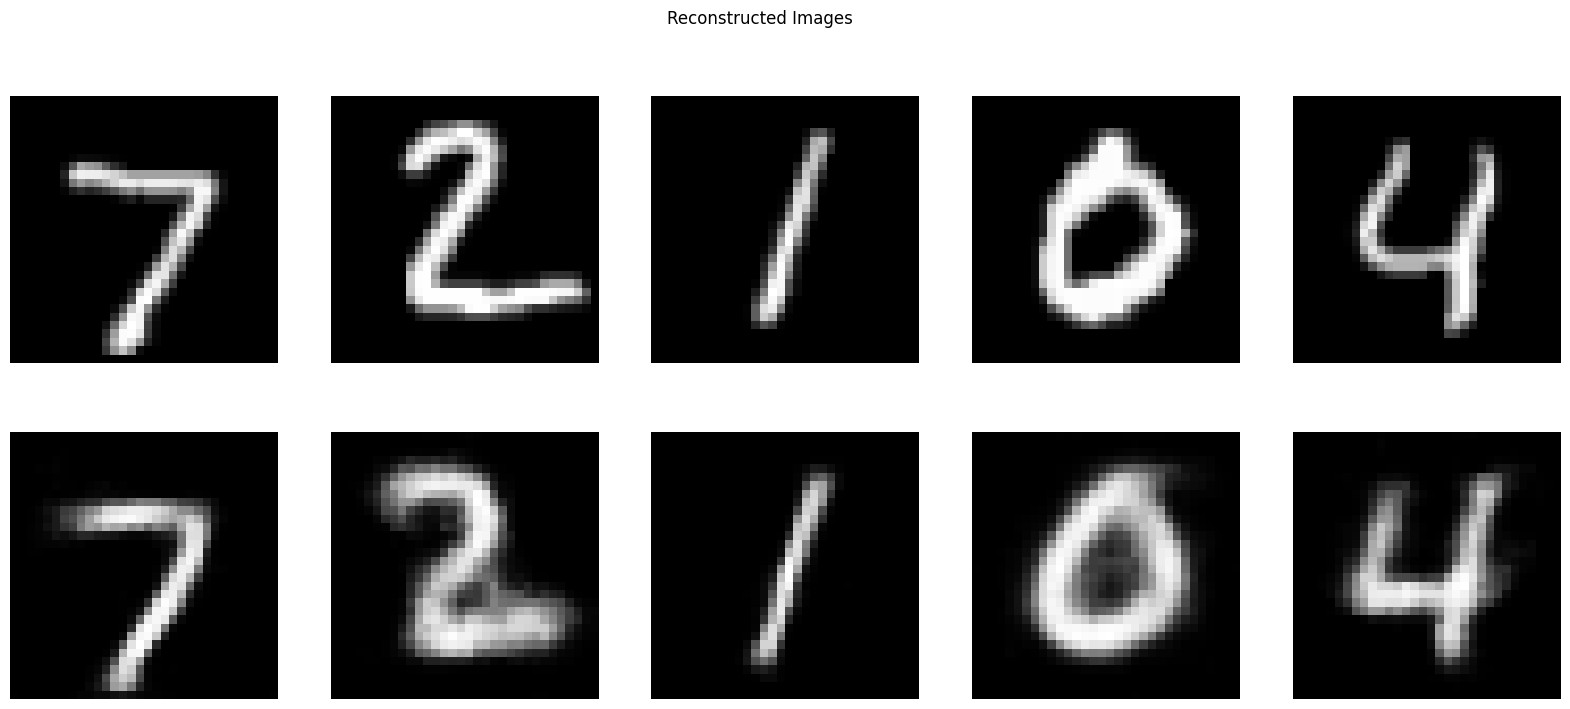

In [9]:
model.eval()
x, y = next(iter(val_loader))

x = x.to(device)
x_hat = model(x, calc_loss=False)[0].detach()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    axs[0, i].imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(x_hat[i].cpu().numpy().squeeze(), cmap="gray")
    axs[1, i].axis("off")

plt.suptitle("Reconstructed Images")
plt.show()

## Denoising Auto Encoder

In [10]:
class Model(nn.Module):
    def __init__(self, latent_dim=4):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Dropout(0.5), # Dropout layer
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),
            
        )

    def forward(self, x, calc_loss) -> tuple[torch.Tensor, torch.Tensor | None]:
        if not calc_loss:
            z = self.encoder(x)
            x_hat = self.decoder(z)
            return x_hat, None

        else:
            z = self.encoder(x)
            x_hat = self.decoder(z)

            loss = F.mse_loss(x_hat, x)
            return x_hat, loss


model = Model().to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
for epoch in range(10):
    model.train()
    val_loss = evaluate(model, val_loader)
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch}")
    for x, _ in pbar:
        x = x.to(device)
        x_hat, loss = model(x, calc_loss=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix_str(
            f"Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Overfit: {loss.item() / val_loss:.4f}"
        )

Epoch 9: 100%|██████████| 469/469 [00:07<00:00, 63.61it/s, Loss: 0.0198, Val Loss: 0.0226, Overfit: 0.8746]


In [13]:
model.eval()
with torch.no_grad():
    values = []
    classes = []
    for x, y in val_loader:
        x = x.to(device)
        z = model.encoder(x)

        values.append(z.cpu().numpy())
        classes.append(y.cpu().numpy().flatten())

    values = np.concatenate(values, axis=0)
    classes = np.concatenate(classes, axis=0)

    # Perform PCA for 3 highest components
    pca = PCA(n_components=2)
    values = pca.fit_transform(values)

    fig = px.scatter(
        x=values[:, 0],
        y=values[:, 1],
        color=classes,
        labels={"values": values},
        title="Latent Space",
        category_orders={"color": np.unique(classes)},
        height=800,
        
    )
    fig.show()

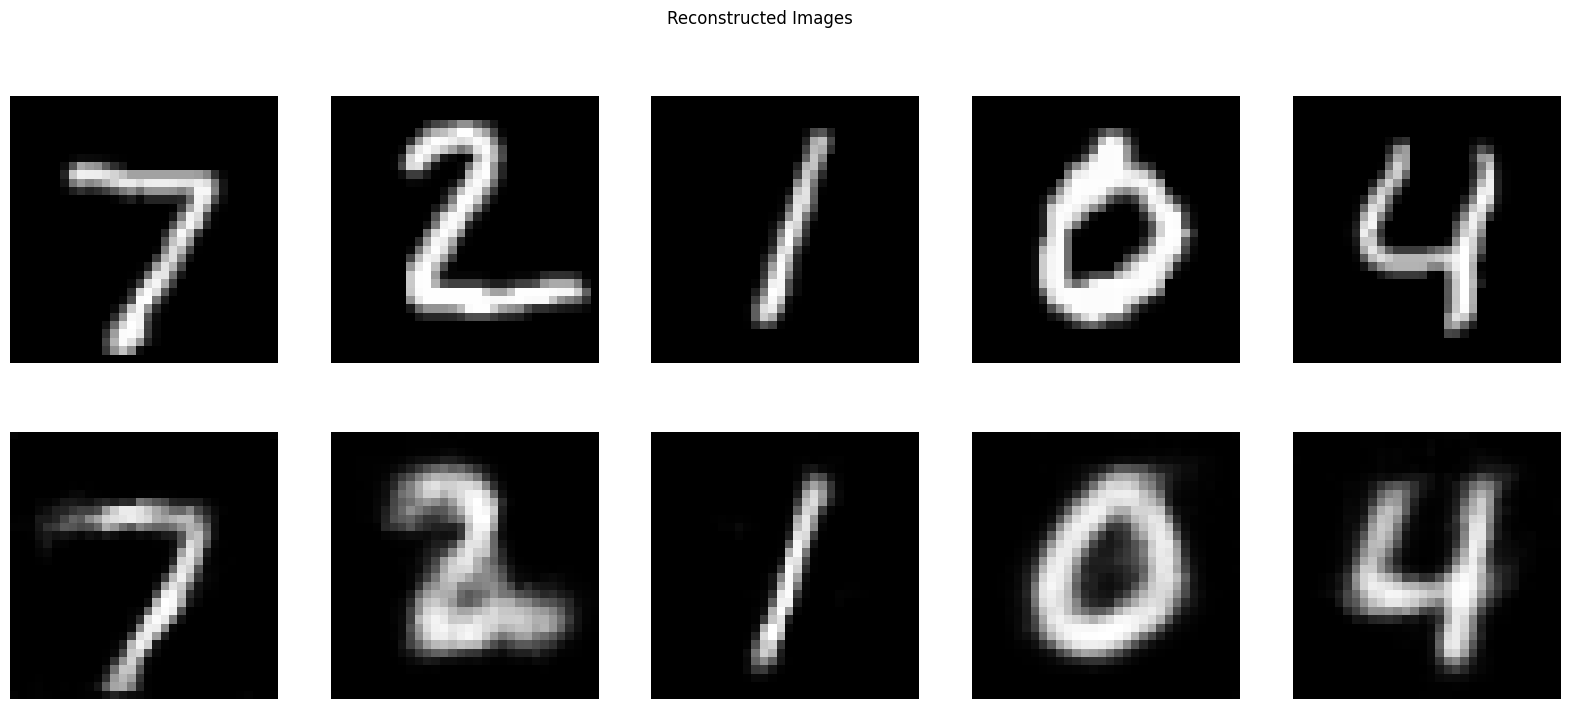

In [14]:
model.eval()
x, y = next(iter(val_loader))

x = x.to(device)
x_hat = model(x, calc_loss=False)[0].detach()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    axs[0, i].imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(x_hat[i].cpu().numpy().squeeze(), cmap="gray")
    axs[1, i].axis("off")

plt.suptitle("Reconstructed Images")
plt.show()

## Variational Auto Encoder

In [57]:
class Model(nn.Module):
    def __init__(self, latent_dim=128):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.logvar = nn.Linear(128 * 4 * 4, latent_dim) # Log variance
        self.mu = nn.Linear(128 * 4 * 4, latent_dim) # Mean

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),
            
        )

    def forward(self, x, calc_loss) -> tuple[torch.Tensor, torch.Tensor | None]:
        if calc_loss:
            z = self.encoder(x)
            mean = self.mu(z)
            logvar = self.logvar(z)
            z = self.reparameterize(mean, logvar)

            x_hat = self.decoder(z)

            loss = F.mse_loss(x_hat, x) + (-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()))
            return x_hat, loss
        
        else:
            z = self.encoder(x)
            mean = self.mu(z)
            logvar = self.logvar(z)
            z = self.reparameterize(mean, logvar)
            x_hat = self.decoder(z)
            return x_hat, None
        
    def reparameterize(self, mean, logvar): # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std, device=device)
        return mean + eps * std
    


model = Model().to(device)

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [59]:
for epoch in range(10):
    model.train()
    val_loss = evaluate(model, val_loader)
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch}")
    for x, _ in pbar:
        x = x.to(device)
        x_hat, loss = model(x, calc_loss=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix_str(
            f"Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Overfit: {loss.item() / val_loss:.4f}"
        )

Epoch 7:  65%|██████▌   | 306/469 [00:04<00:02, 61.84it/s, Loss: 0.0588, Val Loss: 0.0568, Overfit: 1.0351]


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    values = []
    classes = []
    for x, y in val_loader:
        x = x.to(device)
        z = model.encoder(x)

        values.append(z.cpu().numpy())
        classes.append(y.cpu().numpy().flatten())

    values = np.concatenate(values, axis=0)
    classes = np.concatenate(classes, axis=0)

    # Perform PCA for 3 highest components
    pca = PCA(n_components=2)
    values = pca.fit_transform(values)

    fig = px.scatter(
        x=values[:, 0],
        y=values[:, 1],
        color=classes,
        labels={"values": values},
        title="Latent Space",
        category_orders={"color": np.unique(classes)},
        height=800,
        
    )
    fig.show()

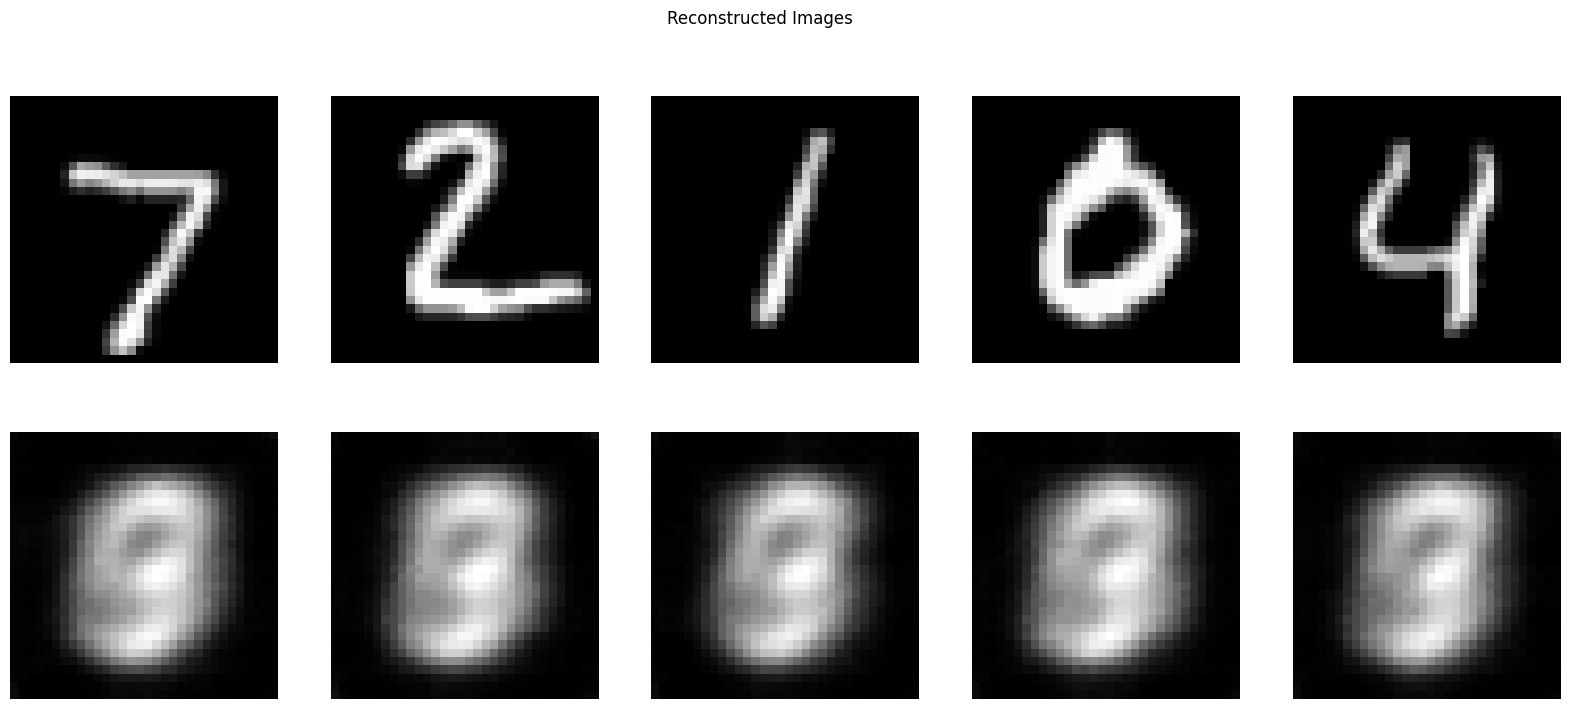

In [54]:
model.eval()
x, y = next(iter(val_loader))

x = x.to(device)
x_hat = model(x, calc_loss=False)[0].detach()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    axs[0, i].imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(x_hat[i].cpu().numpy().squeeze(), cmap="gray")
    axs[1, i].axis("off")

plt.suptitle("Reconstructed Images")
plt.show()

## Sparse Auto Encoder

In [20]:
class Model(nn.Module):
    def __init__(self, latent_dim=4):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),
            
        )

    def forward(self, x, calc_loss) -> tuple[torch.Tensor, torch.Tensor | None]:
        if not calc_loss:
            z = self.encoder(x)
            x_hat = self.decoder(z)
            return x_hat, None

        else:
            z = self.encoder(x)
            x_hat = self.decoder(z)

            loss = F.mse_loss(x_hat, x) + 1e-3 * F.l1_loss(z, torch.zeros_like(z)) # L1 regularization
            return x_hat, loss


model = Model().to(device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
for epoch in range(10):
    model.train()
    val_loss = evaluate(model, val_loader)
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch}")
    for x, _ in pbar:
        x = x.to(device)
        x_hat, loss = model(x, calc_loss=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix_str(
            f"Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Overfit: {loss.item() / val_loss:.4f}"
        )

Epoch 3:  98%|█████████▊| 461/469 [00:08<00:00, 54.40it/s, Loss: 0.0211, Val Loss: 0.0264, Overfit: 0.8000]


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    values = []
    classes = []
    for x, y in val_loader:
        x = x.to(device)
        z = model.encoder(x)

        values.append(z.cpu().numpy())
        classes.append(y.cpu().numpy().flatten())

    values = np.concatenate(values, axis=0)
    classes = np.concatenate(classes, axis=0)

    # Perform PCA for 3 highest components
    pca = PCA(n_components=2)
    values = pca.fit_transform(values)

    fig = px.scatter(
        x=values[:, 0],
        y=values[:, 1],
        color=classes,
        labels={"values": values},
        title="Latent Space",
        category_orders={"color": np.unique(classes)},
        height=800,
        
    )
    fig.show()

In [ ]:
model.eval()
x, y = next(iter(val_loader))

x = x.to(device)
x_hat = model(x, calc_loss=False)[0].detach()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    axs[0, i].imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(x_hat[i].cpu().numpy().squeeze(), cmap="gray")
    axs[1, i].axis("off")

plt.suptitle("Reconstructed Images")
plt.show()